In [3]:
from skimage.external import tifffile
import matplotlib.pyplot as plt
import numpy as np

In [4]:
%matplotlib inline

download muscle segmentaton data from the dryad repository

In [1]:
!wget http://datadryad.org/bitstream/handle/10255/dryad.135236/muscle_segmentation.zip?sequence=1

--2017-12-11 11:12:19--  http://datadryad.org/bitstream/handle/10255/dryad.135236/muscle_segmentation.zip?sequence=1
Resolving datadryad.org (datadryad.org)... 152.14.136.60
Connecting to datadryad.org (datadryad.org)|152.14.136.60|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102177529 (97M) [application/zip]
Saving to: ‘muscle_segmentation.zip?sequence=1’

muscle_segmentation 100%[===================>]  97.44M  11.2MB/s    in 9.3s    

2017-12-11 11:12:29 (10.5 MB/s) - ‘muscle_segmentation.zip?sequence=1’ saved [102177529/102177529]



unzip into the directory muscle segmentation

In [6]:
!unzip muscle_segmentation.zip\?sequence\=1

Archive:  muscle_segmentation.zip?sequence=1
   creating: muscle_segmentation/
  inflating: muscle_segmentation/65G06_brightfield_cuticle.tif  
  inflating: muscle_segmentation/phalloidin_stained_hemithorax.tif  
   creating: muscle_segmentation/65G06_muscle_8bit_ttm_layers/
  inflating: muscle_segmentation/65G06_muscle_8bit_ttm_layers/65G06_muscle_8bit_ttm_layers44.tif  
  inflating: muscle_segmentation/65G06_muscle_8bit_ttm_layers/65G06_muscle_8bit_ttm_layers49.tif  
  inflating: muscle_segmentation/65G06_muscle_8bit_ttm_layers/65G06_muscle_8bit_ttm_layers30.tif  
  inflating: muscle_segmentation/65G06_muscle_8bit_ttm_layers/65G06_muscle_8bit_ttm_layers8.tif  
  inflating: muscle_segmentation/65G06_muscle_8bit_ttm_layers/65G06_muscle_8bit_ttm_layers70.tif  
  inflating: muscle_segmentation/65G06_muscle_8bit_ttm_layers/65G06_muscle_8bit_ttm_layers21.tif  
  inflating: muscle_segmentation/65G06_muscle_8bit_ttm_layers/65G06_muscle_8bit_ttm_layers62.tif  
  inflating: muscle_segmentation

Next I load the segmentation data: stacks of masks that segment 
each muscle from the rest of the tissue.

In [5]:
base_str = "muscle_segmentation/65G06_muscle_8bit_%(mu)s_layers/65G06_muscle_8bit_%(mu)s_layers%(num)s.tif"

segmented_data = {}
for muscle in ['b1','b2','b3','i1','i2',
               'iii1','iii24','iii3',
               'hg1','hg2','hg3','hg3','hg4']:
    
    f_names = [base_str%{'mu':muscle,'num':i} for i in range(74)]
    segmented_data[muscle] = tifffile.imread(f_names,key = 0)
    print(muscle + ' loaded')

b1 loaded
b2 loaded
b3 loaded
i1 loaded
i2 loaded
iii1 loaded


/home/imager/.local/lib/python3.5/site-packages/skimage/external/tifffile/tifffile.py:2611: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


iii24 loaded
iii3 loaded
hg1 loaded
hg2 loaded
hg3 loaded
hg3 loaded
hg4 loaded


Load the phalloidin-stained muscle images. This will be multipled with the mask to form the max intensity image for each muscle. 

In [6]:
ph_staining = tifffile.imread('muscle_segmentation/phalloidin_stained_hemithorax.tif',key = 0)
ph_staining = ph_staining[::-1] #reverse the stack order

finally want to use the bright field image of the cuticle as a backdrop

In [7]:
cuticle = tifffile.imread('muscle_segmentation/65G06_brightfield_cuticle.tif',key = 0)

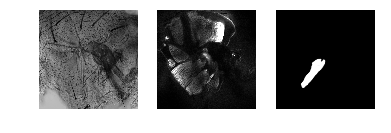

In [8]:
plt.subplot(1,3,1)
plt.imshow(cuticle,cmap = plt.cm.gray)
plt.subplot(1,3,2)
# phalloidin slice #50
plt.imshow(ph_staining[50],cmap = plt.cm.gray)
plt.subplot(1,3,3)
plt.imshow(segmented_data['i1'][50,:,:,3],cmap = plt.cm.gray)
lns = [ax.axis('off') for ax in plt.gcf().axes]

I want to combine the segment masks with the confocal data to create a maximum intensity image for each muscle that only inclueds the segmented pixels. Since I created my mask using the airbrush tool in gimp, each slice of my mask has fuzzy margins that tell where the muscle begins and end.

This is either a good thing or a bad thing depending on your perspective: on one hand my goal in segmenting the data is to define boundries would seem appropriate/ On the other hand, in many cases those bountries are not entierly clear from the images, so my segmentation shoud reflect that. It always possible to convert a greyscale image to binary image by setting a threshold, for example: `binary_img = gray<thresh`. For this reason, I will retain the uncertanty in the segment boundries until it is nessesary to throw away that information. For the purposes of the visualization, I have found it is usefull to soften up the edges  even further by applying a gaussian filter to the mask data.

In [9]:
from scipy.ndimage.filters import gaussian_filter

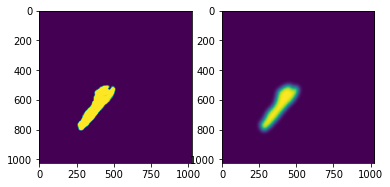

In [10]:
plt.subplot(1,2,1)
plt.imshow(segmented_data['i1'][50,:,:,3])
plt.subplot(1,2,2)
plt.imshow(gaussian_filter(segmented_data['i1'][50,:,:,3],sigma = 15.))

Now I want to create a stack with just the phalloidin staining of i1. To do this I elementwize multiply the phalloidin stack with the blurred stack of masks, but I first need to apply the gaussian filter to the masks. The gaussian_filter function I applied from scipy.ndimage.filters works in n-dimensions and can use an independent sigma for each dimension. I will primarily blurr in x and y but also apply a little across z.

In [11]:
blurred_mask = gaussian_filter(segmented_data['i1'][...,3],
                               sigma = (1.,15.0,15.0))

In [12]:
blurred_mask = blurred_mask.astype(float)

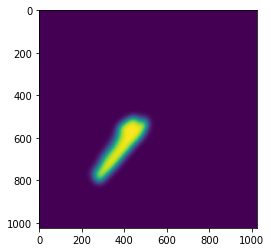

In [13]:
plt.imshow(blurred_mask[50])

I create the max intensity projection by applying `np.max` accross the product of the two stacks.

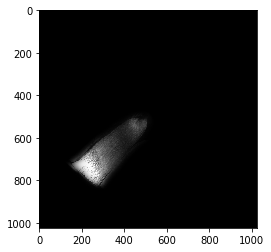

In [14]:
max_projection = np.max(blurred_mask*ph_staining,axis = 0)
max_projection /= np.max(max_projection)
plt.imshow(max_projection,cmap = plt.cm.gray)

This looks decent, but it seems as though the blurring mask bleeds too far outside the segmented image. I could use a narrower distrubtion in my original gaussian filter, but one advange of the wide kernel is that it smoothes out any inconsistancies arising from the brushstrokes I created in gimp. One way of geting the best of both worlds is to pass the blurred data through a power function. Together these operations are functionally similar to a morphological errosion applied to a grayscale image.

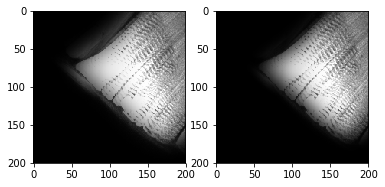

In [28]:
plt.subplot(1,2,1)
plt.imshow(max_projection[650:850,100:300],cmap = plt.cm.gray)
plt.subplot(1,2,2)
sharp_max_projection = np.max(blurred_mask**5 *ph_staining,axis = 0)
sharp_max_projection /= np.max(sharp_max_projection)
plt.imshow(sharp_max_projection[650:850,100:300],cmap = plt.cm.gray)

In [77]:
def max_segmented(muscle = 'i1',sig_z = 1.0,sig_xy = 5.0):
    blurred_mask = gaussian_filter(segmented_data[muscle][...,3],
                               sigma = (sig_z,sig_xy,sig_xy))
    blurred_mask = blurred_mask.astype(float)**8
    max_projection = np.max(blurred_mask*ph_staining,axis = 0)
    max_projection /= np.max(max_projection)
    alpha = np.max(blurred_mask,axis = 0)
    alpha -= np.min(alpha)
    alpha /= np.max(alpha)
    return max_projection,alpha

#maximg,alpha = max_segmented('i1')
#plt.imshow(maximg,cmap = plt.cm.gray)

The matplotlib colomaps are a nice way to colorize the grayscale images but I need to rescale the values from 0-1 first.

Once I've created a color image I want to use the values from segmentation mask to set the transparency. In this way if I plot the muscle over the cuticle image only the segmented pixels get included in the overlay.

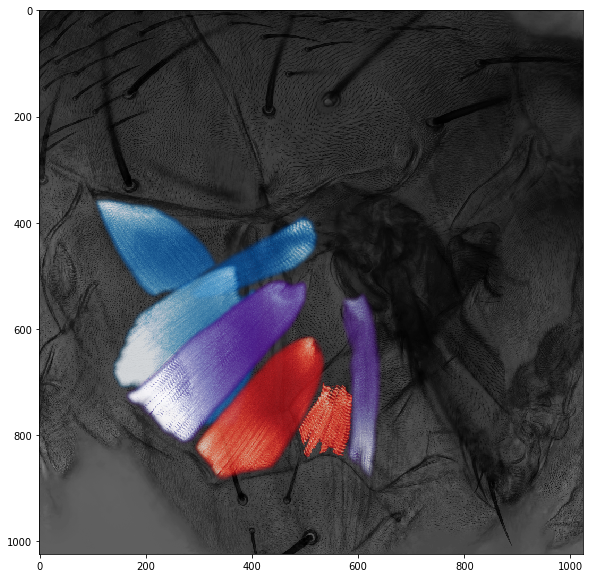

In [80]:
plt.figure(figsize = (10,10))

plt.imshow(cuticle,cmap = plt.cm.gray,clim = (0,500))
#b1
maximg,alpha = max_segmented('b1')
b1_muscle_color = plt.cm.Blues_r(maximg)
b1_muscle_color[...,3] = 0.8*alpha
plt.imshow(b1_muscle_color)

#b3
maximg,alpha = max_segmented('b3')
b3_muscle_color = plt.cm.Blues_r(maximg)
b3_muscle_color[...,3] = 0.8*alpha
plt.imshow(b3_muscle_color)

#b2
maximg,alpha = max_segmented('b2')
b2_muscle_color = plt.cm.Blues_r(maximg)
b2_muscle_color[...,3] = 0.8*alpha
plt.imshow(b2_muscle_color)

#i1
maximg,alpha = max_segmented('i1')
i1_muscle_color = plt.cm.Purples_r(maximg);
i1_muscle_color[...,3] = 0.8*alpha
plt.imshow(i1_muscle_color)

#i2
maximg,alpha = max_segmented('i2')
i2_muscle_color = plt.cm.Purples_r(maximg);
i2_muscle_color[...,3] = 0.8*alpha
plt.imshow(i2_muscle_color)

#iii1
maximg,alpha = max_segmented('i1')
i1_muscle_color = plt.cm.Purples_r(maximg);
i1_muscle_color[...,3] = 0.8*alpha
plt.imshow(i1_muscle_color)

#iii3
maximg,alpha = max_segmented('iii1')
iii1_muscle_color = plt.cm.Reds_r(maximg);
iii1_muscle_color[...,3] = 0.8*alpha
plt.imshow(iii1_muscle_color)

#iii3
maximg,alpha = max_segmented('iii3',sig_z = 0.2,sig_xy = 1.0)
iii3_muscle_color = plt.cm.Reds_r(maximg);
iii3_muscle_color[...,3] = 0.8*alpha
plt.imshow(iii3_muscle_color)

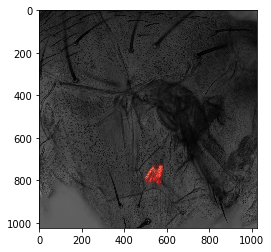

In [76]:
plt.imshow(cuticle,cmap = plt.cm.gray,clim = (0,500))

#iii3
#maximg,alpha = max_segmented('iii3')
#iii3_muscle_color = plt.cm.Reds_r(maximg);
#iii3_muscle_color[...,3] = 1.0*alpha
plt.imshow(iii3_muscle_color)

In [ ]:
imshow(cuticle+i1_muscle_color)

O.K. this seems to work but the image is a bit dark. It would be nice to have more control over the way the color values are combined. What I realy want is to use the hue and saturation of the color from the colorized muscle image but keep the value (darkness/lightness) from the cuticle. To do this I convert both the background and the overlay into HSV (hue,saturation,value) mode using the scikit-image color module, and then add the color data to the hue and saturation channels. In HSV mode I can then use independent alpha parameters to scale the information coming from hue,saturation and value.

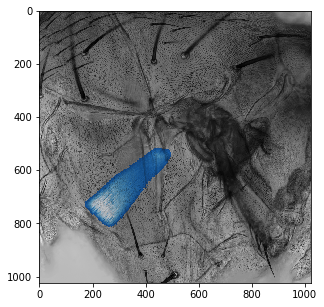

In [57]:
fig = plt.figure(figsize = (5,5))
from skimage import color
cuticle_hsv = color.rgb2hsv(np.dstack([cuticle,cuticle,cuticle]))
b1_hsv = color.rgb2hsv(plt.cm.Blues_r(b1_maximg)[...,:3]*1.2)
mask = b1_maximg>0.05

h_a = 1.0
s_a = 0.9
v_a = 0.4

cuticle_hsv[mask,0] = h_a*b1_hsv[mask,0]+\
                      (1-h_a)*cuticle_hsv[mask,0]

cuticle_hsv[mask,1] = s_a*b1_hsv[mask,1]+\
                      (1-s_a)*cuticle_hsv[mask,1]
    
cuticle_hsv[mask,2] = v_a*b1_hsv[mask,2] + \
                      (1-v_a)*cuticle_hsv[mask,2]

colorized_overlay = color.hsv2rgb(cuticle_hsv)
plt.imshow(colorized_overlay)

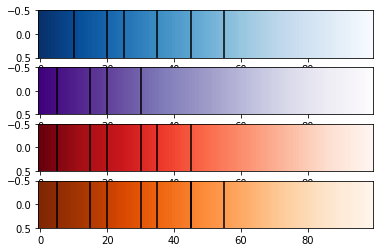

In [58]:
#bassalars
plt.subplot(4,1,1)
plt.imshow([np.linspace(0,1,100)],aspect= 'auto',cmap = plt.cm.Blues_r)
plt.axvline(10,c = 'k');plt.axvline(20,c = 'k')

#first axillary
plt.subplot(4,1,2)
plt.imshow([np.linspace(0,1,100)],aspect= 'auto',cmap = plt.cm.Purples_r)
plt.axvline(5,c = 'k');plt.axvline(15,c = 'k')

#third axillary
plt.subplot(4,1,3)
plt.imshow([np.linspace(0,1,100)],aspect= 'auto',cmap = plt.cm.Reds_r)
plt.axvline(5,c = 'k');plt.axvline(15,c = 'k')
plt.axvline(20,c = 'k');plt.axvline(30,c = 'k')
plt.axvline(35,c = 'k');plt.axvline(45,c = 'k')
plt.subplot(4,1,2)

#Hg
plt.subplot(4,1,4)
plt.imshow([np.linspace(0,1,100)],aspect= 'auto',cmap = plt.cm.Oranges_r)
plt.axvline(5,c = 'k');plt.axvline(15,c = 'k')
plt.axvline(20,c = 'k');plt.axvline(30,c = 'k')
plt.axvline(35,c = 'k');plt.axvline(45,c = 'k')
plt.axvline(45,c = 'k');plt.axvline(55,c = 'k')

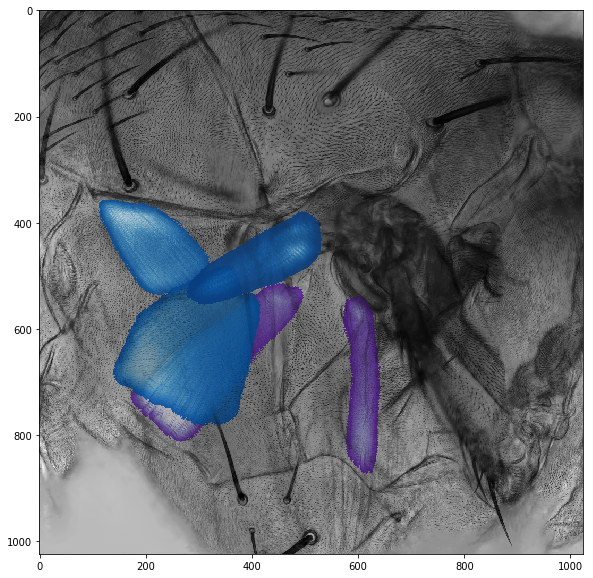

In [61]:
def stack_img(top_img,bottom_img,
              cmap = plt.cm.Blues_r,
              h_a=1.0,  s_a=0.9,  v_a=0.5,
              l_b=0.05, u_b=0.95, thresh = 0.05,
              bleed_gain = 15,blend_alpha = 0.5):
    
    bottom_hsv = color.rgb2hsv(bottom_img)
    #scale from 0 to 1
    top_img -= np.min(top_img);top_img /= np.max(top_img)
    mask = top_img>thresh
    #make the top image values span from the 
    #upper to lower bound within the color map.
    top_img=(top_img*(u_b-l_b) + l_b)
    #convert the top image to HSV
    top_hsv = color.rgb2hsv(cmap(top_img)[...,:3])
    #mix in hue
    bottom_hsv[mask,0] = h_a*top_hsv[mask,0]+\
                          (1-h_a)*bottom_hsv[mask,0]
    #mix in saturation
    bottom_hsv[mask,1] = s_a*top_hsv[mask,1]+\
                          (1-s_a)*bottom_hsv[mask,1]
    #mix in value
    bottom_hsv[mask,2] = v_a*top_hsv[mask,2] + \
                          (1-v_a)*bottom_hsv[mask,2]
    
    colorized_overlay = color.hsv2rgb(bottom_hsv)
    return colorized_overlay


plt.figure(figsize = (10,10))
img = np.dstack([cuticle,cuticle,cuticle])

img = stack_img(max_segmented('i1'),img,plt.cm.Purples_r)
img = stack_img(max_segmented('b1'),img,plt.cm.Blues_r,v_a = 0.8)
img = stack_img(max_segmented('b2'),img,plt.cm.Blues_r,v_a = 0.4,l_b = 0.05,u_b=0.6)
img = stack_img(max_segmented('b3'),img,plt.cm.Blues_r,v_a = 0.8,l_b = 0.05,u_b=0.6,thresh = 0.001)
img = stack_img(max_segmented('i2'),img,plt.cm.Purples_r,l_b = 0.05,u_b=0.6)

plt.imshow(img)